#### Optimal Opponent Experiments
Author: Yemi Kelani

##### Google Drive Setup (Skip if running locally)

> To run this notebook, follow these steps:
> 1. Download the latest version of the [repository](https://github.com/yemi-kelani/artificial-intelligence/tree/master).
> 2. Upload the repsitory files to your Google Drive account under the path `Projects/artificial-intelligence`.
> 3. Open this file (`train.ipynb`) from your Google Drive and run the experiments.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
ROOT_FOLDER = "drive/MyDrive/Projects/artificial-intelligence/models/ReinforcementLearning/"
PROJECT_PATH = f"{ROOT_FOLDER}/DeepQ_TicTacToe_v2"
NOTEBOOK_LOCATION = f"{PROJECT_PATH}/experiments"

In [ ]:
!cp {PROJECT_PATH}/DeepQAgent.py .
!cp {PROJECT_PATH}/TicTacToeGame.py .
!cp {ROOT_FOLDER}/Utils.py .

from DeepQAgent import DeepQAgent
from TicTacToeGame import TicTacToeGame, OPPONENT_LEVEL
from Utils import (
    train_agent,
    test_agent
)
MODEL_PATH = "drive/MyDrive/Projects/artificial-intelligence/trained_models/ReinforcementLearning/TicTacToeV2"

##### Local Setup (Skip if running remotely)

> 1. Run the following cells

In [1]:
from models.ReinforcementLearning.DeepQ_TicTacToe_v2.DeepQAgent import DeepQAgent
from models.ReinforcementLearning.DeepQ_TicTacToe_v2.TicTacToeGame import TicTacToeGame, OPPONENT_LEVEL
from models.ReinforcementLearning.Utils import (
    train_agent,
    test_agent
)
MODEL_PATH = "../../../../trained_models/ReinforcementLearning/TicTacToeV2"

##### Experiments

In [2]:
import os
import torch

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# DeepQ parameters
LEARNING_RATE      = 0.001
MOEMENTUM          = 0.90
NUM_EPISODES       = 10000
EPSILON            = 1.0
GAMMA              = 0.95
STATE_SPACE        = 9
ACTION_SPACE       = 9
HIDDEN_SIZE        = 128
DROPOUT            = 0.20
TRAIN_START        = 1000
BATCH_SIZE         = 256
MEMORY_MAX_LEN     = 2000
USE_TARGET_NETWORK = True
NETWORK_SYNC_RATE  = 3

# model save-path roots
BASELINE = "TicTacToe-v2-BASELINE"
NAIVE    = "TicTacToe-v2-NAIVE"
AGENT    = "TicTacToe-v2-AGENT"
OPTIMAL  = "TicTacToe-v2-OPTIMAL"
SELF     = "TicTacToe-v2-SELF"

def get_full_model_path(agent_name: str = None):
  if agent_name is None:
    return os.path.join(MODEL_PATH, "" + ".pt")
  return os.path.join(MODEL_PATH, agent_name + ".pt")

def supply_model(
  load_if_exists: bool = True, 
  agent_name: str = None,
  optimizer_type = ""
  ):

  agent = DeepQAgent(
      device             = DEVICE,
      epsilon            = EPSILON,
      gamma              = GAMMA,
      state_space        = STATE_SPACE,
      action_space       = ACTION_SPACE,
      hidden_size        = HIDDEN_SIZE,
      dropout            = DROPOUT,
      train_start        = TRAIN_START,
      batch_size         = BATCH_SIZE,
      memory_max_len     = MEMORY_MAX_LEN,
      use_target_network = USE_TARGET_NETWORK,
      network_sync_rate  = NETWORK_SYNC_RATE
  )

  full_model_path = get_full_model_path(agent_name)
  if load_if_exists and os.path.exists(full_model_path):
    print("Loading Model Parameters...")
    agent.load_model(filepath=full_model_path)

  match optimizer_type.upper():
    case "SGD":
      optimizer = torch.optim.SGD(
        agent.parameters(), 
        lr=LEARNING_RATE, 
        momentum=MOEMENTUM
      )
    case "RMS":
      optimizer = torch.optim.RMSprop(agent.parameters(), lr=LEARNING_RATE)
    case "ADAM":
      optimizer = torch.optim.Adam(agent.parameters(), lr=LEARNING_RATE)
    case _:
      optimizer = torch.optim.Adam(agent.parameters(), lr=LEARNING_RATE)
      
  # criterion = torch.nn.SmoothL1Loss() # Huber Loss
  criterion = torch.nn.MSELoss()
  
  return agent, optimizer, criterion

def compare_to_naive(agent_name: str, num_episodes: int = 10000):
  _agent, _, _ = supply_model(load_if_exists=True, agent_name=agent_name)
  _environment = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.NAIVE, start_as_X=True)
  test_agent(_agent, _environment, num_episodes)

def compare_to_optimal(agent_name: str, num_episodes: int = 100):
  _agent, _, _ = supply_model(load_if_exists=True, agent_name=agent_name)
  _environment = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.OPTIMAL, start_as_X=True)
  test_agent(_agent, _environment, num_episodes)

def compare_to_model(agent_name: str, model_name: str, num_episodes: int = 10000):
  _agent, _, _ = supply_model(load_if_exists=True, agent_name=agent_name)
  _enemy, _, _ = supply_model(load_if_exists=True, agent_name=model_name)
  _environment = TicTacToeGame(DEVICE, _enemy, OPPONENT_LEVEL.AGENT, start_as_X=True)
  test_agent(_agent, _environment, num_episodes)


cpu


In [3]:
agent, _, _ = supply_model()
agent.save_model(MODEL_PATH, BASELINE)

Model saved to '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt'.


'../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt'

In [ ]:
compare_to_naive(BASELINE)

Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-BASELINE.pt'.
episode: 1/10000, steps: 4, reward_total: -1, loss_avg: n/a, e: 1.0, time: 12:35:04
_______
|X|O|X|
|O|X|O|
|X|O|X|
‾‾‾‾‾‾‾
episode: 2/10000, steps: 4, reward_total: 1, loss_avg: n/a, e: 1.0, time: 12:35:04
_______
|O| |X|
|O|O|X|
|X|X|O|
‾‾‾‾‾‾‾
episode: 3/10000, steps: 3, reward_total: -1, loss_avg: n/a, e: 1.0, time: 12:35:04
_______
|X|X|X|
|X|O| |
| |O|O|
‾‾‾‾‾‾‾
episode: 4/10000, steps: 3, reward_total: -1, loss_avg: n/a, e: 1.0, time: 12:35:04
_______
|O| | |
|X|X|X|
|X|O|O|
‾‾‾‾‾‾‾
episode: 5/10000, steps: 3, reward_total: 1, loss_avg: n/a, e: 1.0, time: 12:35:04
_______
|X|O|X|
| |O| |
| |O|X|
‾‾‾‾‾‾‾
episode: 6/10000, steps: 4, reward_total: -1, loss_avg: n/a, e: 1.0, time: 12:35:04
_______
|O|X|O|
|O|O|X|
|X|X|X|
‾‾‾‾‾‾‾
episode: 7/10000, steps: 2, reward_total: -1, loss_avg: n/a, e: 1.0, time: 12:35:04
_______
| |O|O|
|X|X|X|
| | | |
‾‾‾‾‾‾‾

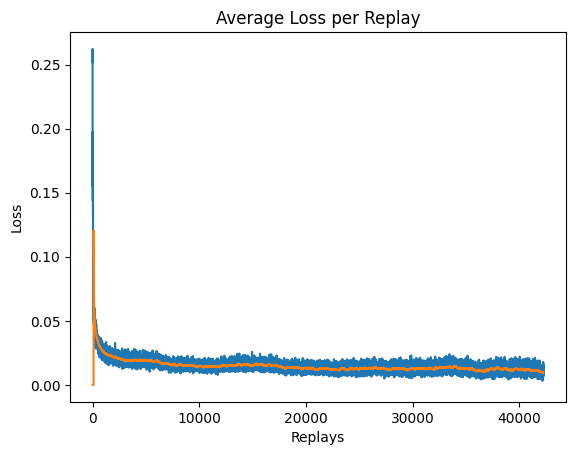

In [4]:
agent, optimizer, criterion = supply_model(
    load_if_exists=True, 
    agent_name=BASELINE,
    optimizer_type="ADAM"
)
agent.LOG_DETAILS = False
# agent.prep_cosine_anneal(0.0, 1.0, NUM_EPISODES)
environment = TicTacToeGame(DEVICE, None, OPPONENT_LEVEL.NAIVE)
reward_history = train_agent(
    agent,
    environment,
    NUM_EPISODES,
    optimizer,
    criterion,
    DEVICE,
    MODEL_PATH,
    model_name = NAIVE,
    save_every = 2000,
    # epsilon_min_value = 0.30,
    # epsilon_max_value = 0.75,
)
agent.plot_loss_history()

In [5]:
compare_to_naive(f"{NAIVE}-2K")
compare_to_optimal(f"{NAIVE}-2K")

Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-2K.pt'.


100%|██████████| 10000/10000 [00:15<00:00, 639.01it/s]




Win rate:  50.92%
Draw rate: 13.09%
Loss rate: 35.99%
Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-2K.pt'.


100%|██████████| 100/100 [02:16<00:00,  1.37s/it]



Win rate:  0.0%
Draw rate: 0.0%
Loss rate: 100.0%


In [6]:
compare_to_naive(f"{NAIVE}-4K")
compare_to_optimal(f"{NAIVE}-4K")

Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-4K.pt'.


100%|██████████| 10000/10000 [00:14<00:00, 669.40it/s]




Win rate:  55.07%
Draw rate: 7.17%
Loss rate: 37.76%
Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-4K.pt'.


100%|██████████| 100/100 [02:17<00:00,  1.37s/it]



Win rate:  0.0%
Draw rate: 0.0%
Loss rate: 100.0%


In [7]:
compare_to_naive(f"{NAIVE}-6K")
compare_to_optimal(f"{NAIVE}-6K")

Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-6K.pt'.


100%|██████████| 10000/10000 [00:15<00:00, 653.56it/s]




Win rate:  42.97%
Draw rate: 10.27%
Loss rate: 46.76%
Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-6K.pt'.


100%|██████████| 100/100 [02:17<00:00,  1.37s/it]



Win rate:  0.0%
Draw rate: 12.0%
Loss rate: 88.0%


In [8]:
compare_to_naive(f"{NAIVE}-8K")
compare_to_optimal(f"{NAIVE}-8K")

Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-8K.pt'.


100%|██████████| 10000/10000 [00:15<00:00, 640.08it/s]




Win rate:  44.95%
Draw rate: 5.62%
Loss rate: 49.43%
Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-8K.pt'.


100%|██████████| 100/100 [02:17<00:00,  1.38s/it]



Win rate:  0.0%
Draw rate: 0.0%
Loss rate: 100.0%


In [9]:
compare_to_naive(f"{NAIVE}-10K")
compare_to_optimal(f"{NAIVE}-10K")

Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-10K.pt'.


100%|██████████| 10000/10000 [00:15<00:00, 643.80it/s]




Win rate:  53.66%
Draw rate: 6.46%
Loss rate: 39.88%
Loading Model Parameters...
Model loaded from '../../../../trained_models/ReinforcementLearning/TicTacToeV2/TicTacToe-v2-NAIVE-10K.pt'.


100%|██████████| 100/100 [02:20<00:00,  1.40s/it]



Win rate:  0.0%
Draw rate: 0.0%
Loss rate: 100.0%
